# Проксимальный метод

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib
import cvxpy as cvx
from step_size import ConstantStepSize, SeqStepSize, StepSize

from methods import GradientDescent as SubgradMethod

In [2]:
import sklearn.preprocessing as skprep

In [3]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 4,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

## Мотивировка

- "Многие методы первого порядка (методы градиентного типа) основаны на использовании квадратичной функции (параболоида вращения) в качестве оптимизации модели. Однако необязательно рассматривать именно параболоиды вращения. Можно использовать и другие функции, которые позволяют построить более точную локальную модель целевой функции задачи в рассматриваемой точке, что приводит в итоге к увеличению скорости сходимости метода. Здесь можно выделить два направления. Первое направление связано с использованием старших производных в модели функции, а второе — с занесением в модель части постановки задачи. Например, если оптимизируемая функция есть сумма гладкой и негладкой функций, то первую можно заменять параболоидом вращения в модели, а вторую оставить как есть. Насколько нам известно, по такому подходу до последнего момента имелись лишь разрозненные результаты."
Источник: Р. Ф. Хильдебранд, Е. А. Воронцова, 
А. В. Гасников, Ф. С. Стоняки "Выпуклая 
оптимизациян65

## Общее понятие проксимального оператора

Пусть $f : \mathbb{R}^n \to \mathbb{R}$ замкнутая выпуклая функция (не обязательно гладкая), т.е. её надграфик  

$$\text { epi } f=\left\{(x, t) \in \mathbf{R}^n \times \mathbf{R} \mid f(x) \leq t\right\}$$
является закрытым выпуклым множеством. (Почему это условие существенно?)  

$$\operatorname{dom} f=\left\{x \in \mathbf{R}^n \mid f(x)<+\infty\right\}$$
множество точек, на которых $f$ ограничена.  

Проксимальным оператором называется функция вида:
$$\operatorname{prox}_f(v)=\underset{x}{\operatorname{argmin}}\left(f(x)+(1 / 2)\|x-v\|_2^2\right)  \ \ \ \ \ \ \ \ (1)$$

## Проксимальный оператор для негладкой функции

Предположим, что функцию $f$ возможно представить как сумму $f(x) = \phi(x) + h(x)$, где $\phi(x)$ - выпуклая гладкая функция, а $h(x)$ - выпуклая негладкая функция. Определим аппроксимационную подзадачу:

$$q_\lambda(x_k)=\underset{x}{\operatorname{argmin}}\left(\phi(x_k) + \nabla \phi(x_k)^\top(x - x_k) + h(x) + (1 / 2 \lambda) \| x-x_k \|_2^2 \right)$$

Можно показать, что для такой подзадачи проксимальный оператор примет вид:  
$$x_{k+1} := \operatorname{prox}_{\lambda^k h}(x_k - \lambda_k \nabla \phi(x_k))  \quad (2)$$
Подробнее см. N. Parikh and S. Boyd. "Proximal Algorithms." с. 148    

__Примечание__ Отсюда видим, что при $h(x)=0$ получаем обычный градиентный метод  
__Примечание__ При $\phi(x)=0$ получаем проксимальный метод (1)

__Примечание__ Данный метод используют для ускорения обычного субградиентного метода, так как при постоянном шаге он не сходится вблизи изломов негладких функций

## Проксимальный метод. Код

In [4]:
class ProxGM:
    def __init__(self, fix_lam=None, lam0=1, beta=0.5, return_history=True, name=None):
        self.name = name
        self.return_history = return_history
        self.history = []
        self.lam0 = lam0
        self.fix_lam = fix_lam
        self.beta = beta

    def backtracking(self, x, f, gradf, g_prox):
        lam = self.lam0
        f_x = f(x)
        f_grad_x = gradf(x)
        z = g_prox(x - lam * f_grad_x, lam)
        while f(z) > f_x + np.sum(f_grad_x * (z - x)) + np.linalg.norm(z - x) ** 2 / (2 * lam):
            lam = lam * self.beta
            z = g_prox(x - lam * gradf(x), lam)
            self.lam0 = lam
            if lam <= 1e-9:
                break
        return z

    def solve(self, x0, f, gradf, g_prox, tol=1e-3, max_iter=10000):
        x = x0.copy()
        self.history = [(x, time.time())]
        for i in range(max_iter):
            if self.fix_lam is None:
                x = self.backtracking(x, f, gradf, g_prox)
            else:
                x_ = x - self.fix_lam * gradf(x)
                x = g_prox(x_, self.fix_lam)
            self.history.append((x, time.time()))
        return x


class AccProxGM(ProxGM):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def solve(self, x0, f, gradf, g_prox, tol=1e-3, max_iter=10000):
        x = x0.copy()
        x_prev = x.copy()
        self.history = [(x, time.time())]
        t_prev = 1
        t_next = (1 + np.sqrt(1 + 4 * t_prev ** 2)) / 2.
        for i in range(max_iter):
            w = (t_prev - 1) / t_next
            x, x_prev = x + w * (x - x_prev), x
            t_prev = t_next
            t_next = (1 + np.sqrt(1 + 4 * t_prev ** 2)) / 2.
            if self.fix_lam is None:
                x = self.backtracking(x, f, gradf, g_prox)
            else:
                x_ = x - self.fix_lam * gradf(x)
                x = g_prox(x_, self.fix_lam)
            self.history.append((x, time.time()))
        return x

## Вычислительные эксперименты. Регрессия Lasso

Решим задачу LASSO:

$$
\min_x f(x) 
$$
, где $f(x) = \frac{1}{2}\|Ax - y \|^2_2 + \gamma \|x\|_1$

Воспользуемся проксимальным методом. Для этого представим $f(x)$ как композитную задачу:  
- $\phi(x) = \frac{1}{2}\|Ax - y \|^2_2$
- $h(x) = \gamma \|x\|_1$

Вычислим проксимальный оператор (2) для этой задачи:

$$ 
x_{k+1} = \begin{cases} x_i - \lambda & x_i \geq \lambda  \\ 0 & |x_i| \leq \lambda \\ x_i + \lambda & x_i \leq -\lambda \end{cases}
$$
Или в векторизованном виде:  
$$
x_{k+1} = \text{sign}(x)(|x| - \lambda)_+, \; |x| = (|x_1|, \ldots, |x_n|)
$$


Сравним проксимальный метод с субградиентным методом c постоянным шагом $h = 5 \cdot 10^{-4}$ (шаг подобран эмпирически), на графике будет обозначен как "Subgradient Method", а так же с ускоренной методом композитной оптимизации, на графике будет обозначен как "AccProxGM". Стандартный метод композитной оптимизации будет обозначен как "ProxGM".


$$x_{k+1} = x_k - h \nabla f(x_k)$$
, где $h = 5 \cdot 10^{-4}$


Подготовим данные

In [5]:
m = 500
n = 2500

np.random.seed(1)

A = np.random.rand(m, n)
A = skprep.normalize(A, norm="l2", axis=0) # нормировка строк матрицы

x_true = np.random.randn(n)
x_true[np.random.rand(n) < 0.96] = 0 # сделаем вектор разреженным
print("Number of nonzeros in x_true = {}".format(np.sum(x_true != 0)))

v = 9e-2 * np.random.randn(m)
y = A.dot(x_true) + v
gamma_max = np.linalg.norm(A.T.dot(y), ord=np.inf)
gamma = 0.1 * gamma_max

print("Gamma = {}".format(gamma))
print("S2N ratio = {}".format(np.linalg.norm(A.dot(x_true)) ** 2 / np.linalg.norm(v) ** 2))
x0 = np.random.rand(n)

L = np.linalg.eigvalsh(A.T.dot(A)).max()

Number of nonzeros in x_true = 84
Gamma = 1.2180047577704627
S2N ratio = 46.16567095285224


Функции

In [6]:
F = lambda x: np.linalg.norm(A.dot(x) - y) ** 2 / 2 + gamma * np.sum(np.abs(x))
subgradF = lambda x: A.T.dot(A.dot(x) - y) + gamma * np.sign(x) # для субградиентного метода

f = lambda x: np.linalg.norm(A.dot(x) - y) ** 2 / 2
gradf = lambda x: A.T.dot(A.dot(x) - y)

g_prox = lambda h, alpha: np.sign(h) * np.maximum(np.abs(h) - alpha * gamma, 0) # проксимальный оператор

Запуск методов

In [7]:
num_iter = 2000
methods = []

method = SubgradMethod(ConstantStepSize(5e-4), name="Subgradient Method, const step")
x_subgrad = method.solve(x0, F, subgradF, tol=0, max_iter=num_iter)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x_subgrad != 0)))
print("\tf^* = {}".format(F(x_subgrad)))

method = ProxGM(name="ProxGM")
x = method.solve(x0, f, gradf, g_prox, max_iter=num_iter)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x != 0)))
print("\tf* = {}".format(F(x)))

method = AccProxGM(fix_lam=None, name="AccProxGM")
x_acc = method.solve(x0, f, gradf, g_prox, max_iter=num_iter)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x_acc != 0)))
print("\tf* = {}".format(F(x_acc)))

Subgradient Method, const step
	Number nonzeros in x* = 2500
	f^* = 26.313351753418964
ProxGM
	Number nonzeros in x* = 309
	f* = 26.164257420296543
AccProxGM
	Number nonzeros in x* = 31
	f* = 24.48417330043385


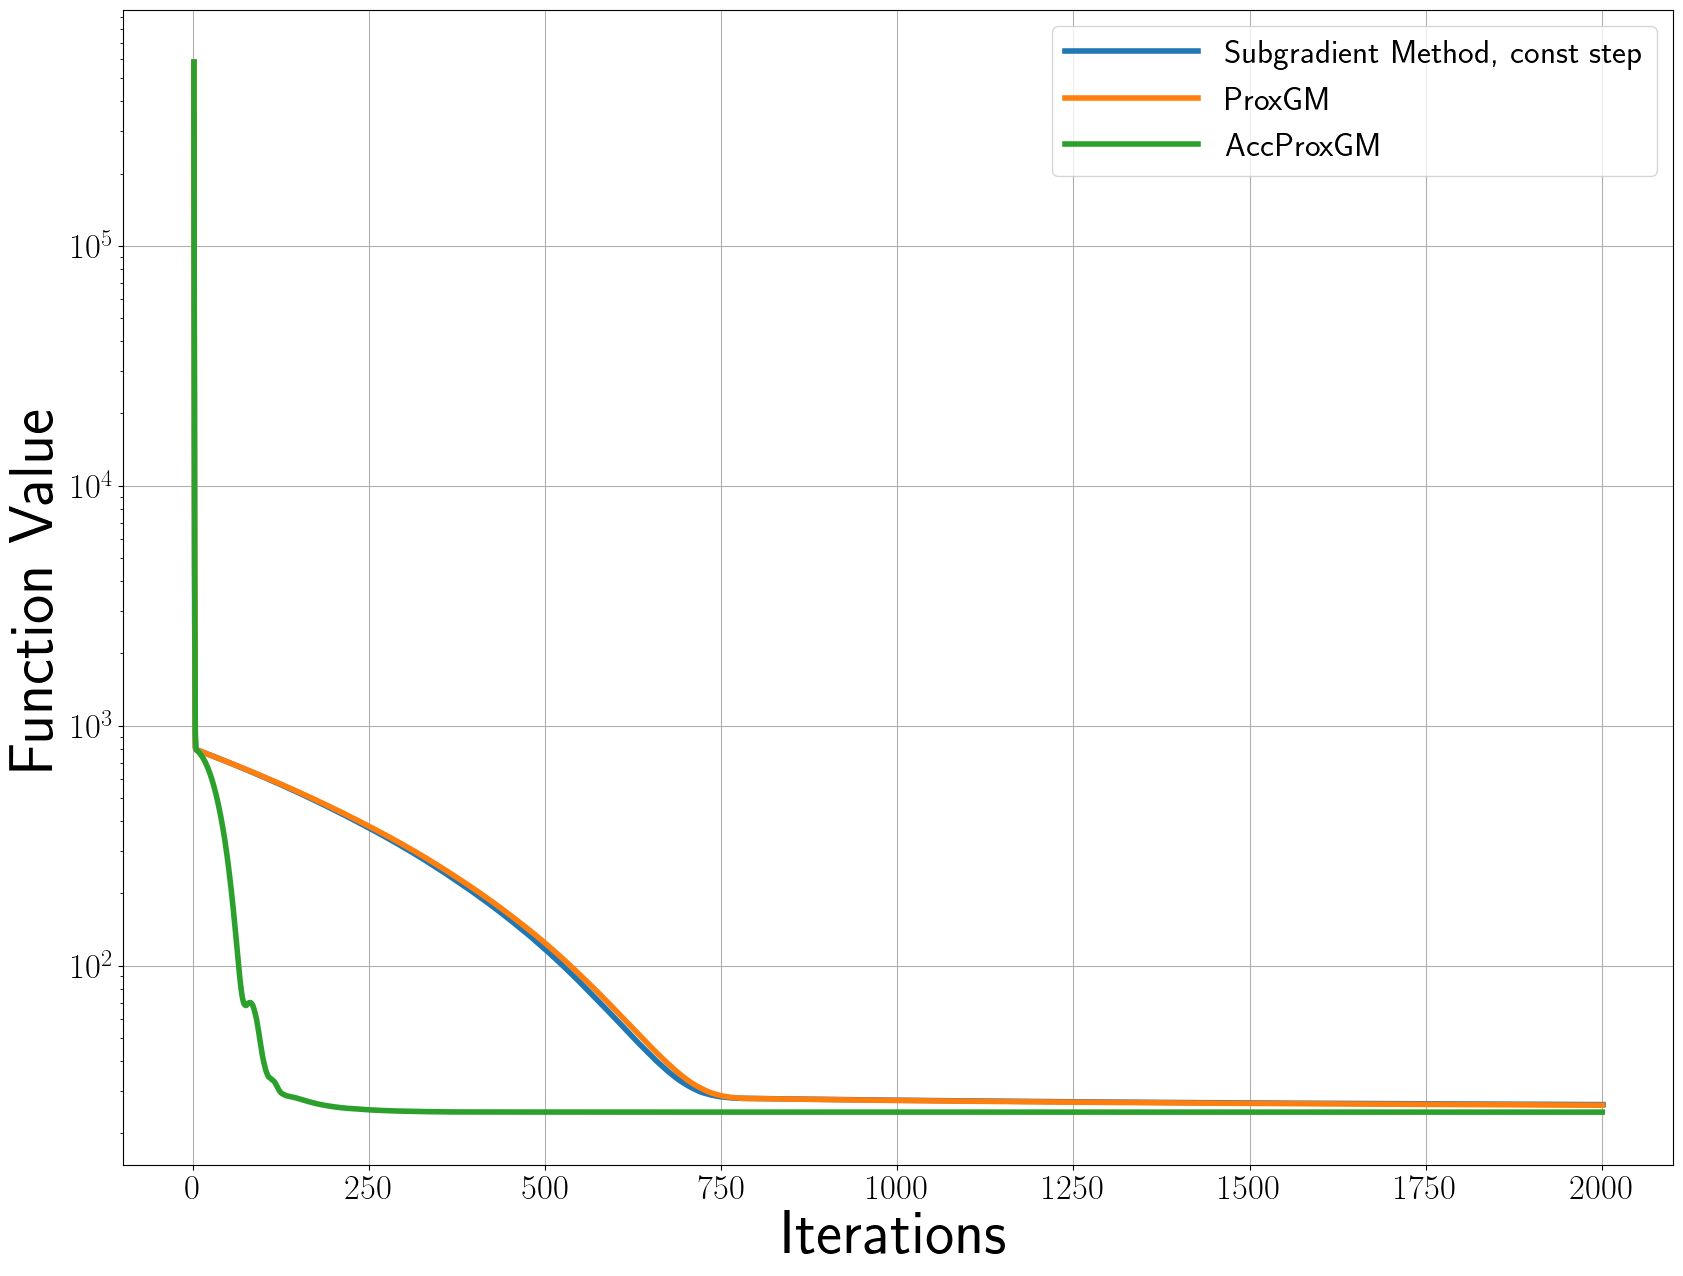

In [8]:
%matplotlib inline
plt.rc("text", usetex=True)
plt.figure(figsize=(20, 15))

for method in methods:
    hist = [F(x) for x, _ in method.history]
    plt.semilogy(range(1, len(hist) + 1), hist, label=method.name)
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Function Value")
plt.legend(loc="best", fontsize=24);

Что даёт адаптивность? Если нам неизвестна $L$, то мы можем искать константу $L$ на каждой итерации (тут $L = 1 / \alpha$):

$$h(x_{k+1})\leq h(x_k) + \langle \nabla h_k, x_{k+1}-x_k \rangle + \frac{1}{2\alpha}\|x_k-x_{k+1}\|^2$$

__Примечание__ Скорость сходимости $\mathcal{O}(1/k)$ для шага $\alpha_k \equiv \alpha \in (0, 1/L]$, где $L$ - константа Липшица градиента $h'$ (стандартная для выпуклой оптимизации лемма, см. например, Ю.Е. Нестеров "Введение в выпуклую оптимизацию", с. 47)

Сравним методы с постоянными шагами и с адаптивным

In [37]:
num_iter = 2000
methods = []

method = ProxGM(name="ProxGM, adapt")
x = method.solve(x0, f, gradf, g_prox, max_iter=num_iter)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x != 0)))
print("\tf* = {}".format(F(x)))

method = ProxGM(name="ProxGM, 2/L", fix_lam=2.1/L)
x = method.solve(x0, f, gradf, g_prox, max_iter=num_iter)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x != 0)))
print("\tf* = {}".format(F(x)))

method = ProxGM(name="ProxGM, 1/2L", fix_lam=1/(2*L))
x = method.solve(x0, f, gradf, g_prox, max_iter=num_iter)
methods.append(method)
print(method.name)
print("\tNumber nonzeros in x* = {}".format(np.sum(x != 0)))
print("\tf* = {}".format(F(x)))

ProxGM, adapt
	Number nonzeros in x* = 309
	f* = 26.164257420296543
ProxGM, 2/L
	Number nonzeros in x* = 2500
	f* = 2.046126292454048e+171
ProxGM, 1/2L
	Number nonzeros in x* = 439
	f* = 27.197129012666938


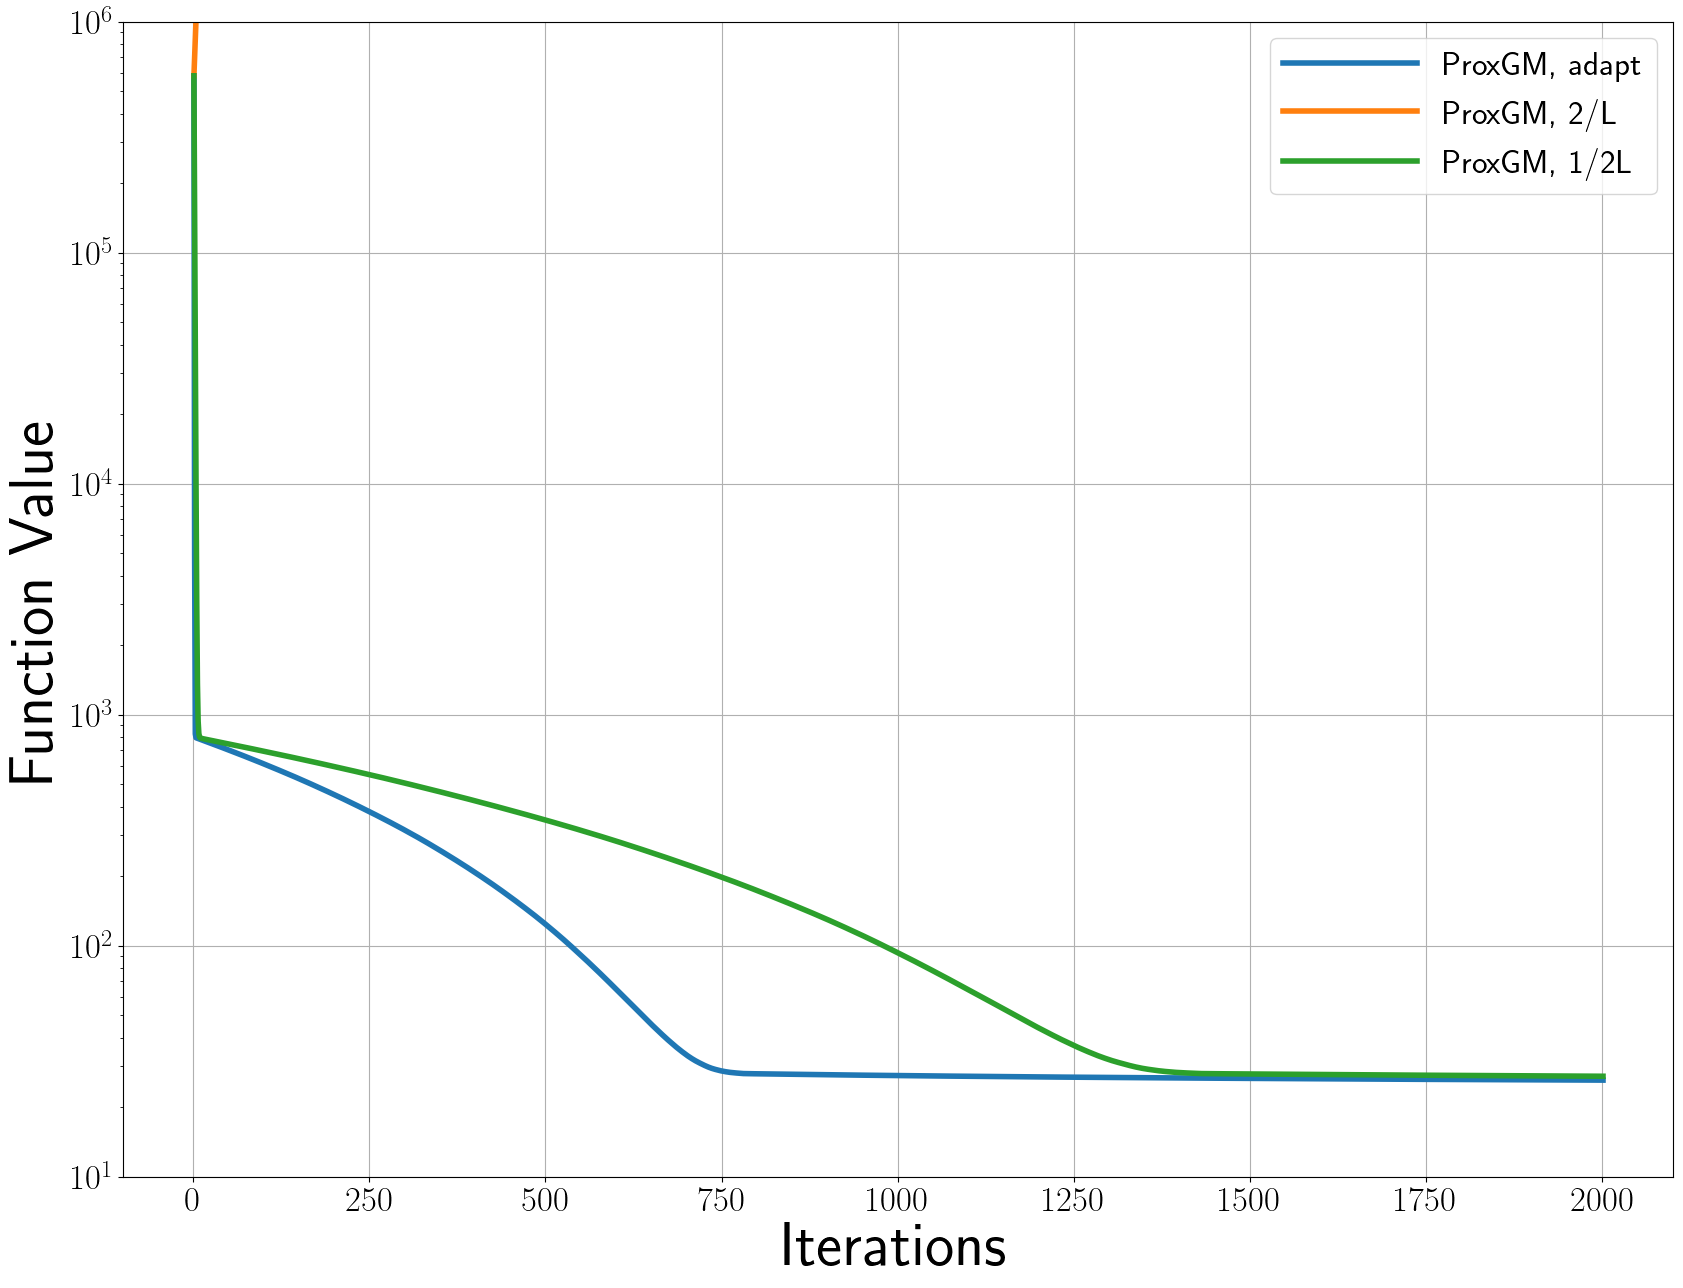

In [41]:
%matplotlib inline
plt.rc("text", usetex=True)
plt.figure(figsize=(20, 15))

for method in methods:
    hist = [F(x) for x, _ in method.history]
    plt.semilogy(range(1, len(hist) + 1), hist, label=method.name)
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Function Value")
plt.ylim((1e+1, 1e+6))
plt.legend(loc="best", fontsize=24);

Как видим, при неправильно подобранном шаге метод может расходиться. Адаптивность же позволяет предотвратить это